In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ugradio as ug
import scipy.constants as consts

In [2]:
sundata = np.load('Sun2019final.npz')

In [3]:
times = sundata['time']
volts = sundata['volts']

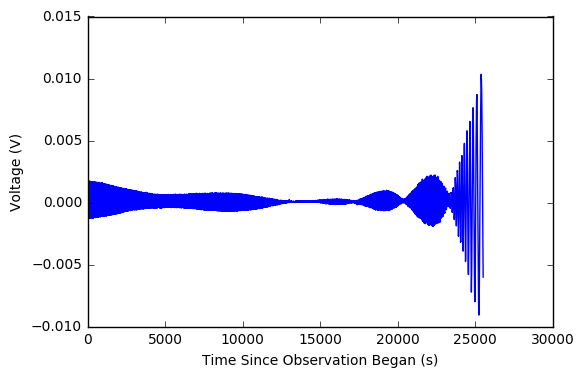

In [4]:
plt.plot(times - times[0], volts)
plt.ylabel('Voltage (V)')
plt.xlabel('Time Since Observation Began (s)')
plt.show()

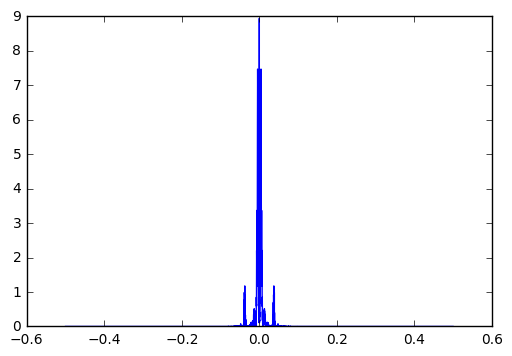

In [5]:
fouriervolts = np.fft.fft(volts)
power = abs(fouriervolts)**2
freqs = np.fft.fftfreq(len(volts))
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(power))
plt.show()

In [6]:
fvolts = np.copy(fouriervolts)
fvolts[np.where(np.abs(freqs) > 0.1)] = 0 
fvolts[np.where(np.abs(freqs) < 0.02)] = 0

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


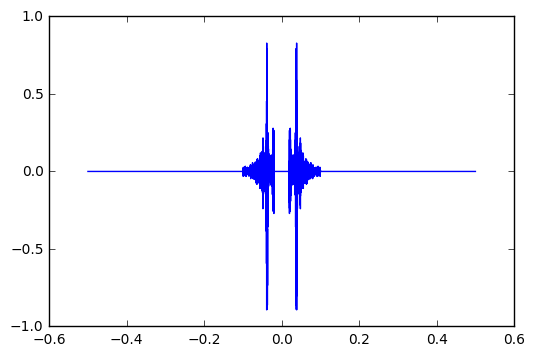

In [10]:
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(fvolts))
plt.show()

In [11]:
voltsfilt = np.fft.ifft(fvolts)

In [5]:
unixtime = times
JDtime = ug.timing.julian_date(unixtime)
LSTtime = ug.timing.lst(jd = JDtime)*180/np.pi #convert LSTtime from rad to deg # now DEG

Get RA values for CRAB observation

In [6]:
#ra = 83.6333

In [7]:
#ra = [ug.coord.sunpos(time)[0] for time in JDtime]
#np.savez('SunRAvalues.npz', data=ra)

In [8]:
ra = np.load('SunRAvalues.npz')['data'] #RA in DEG

In [9]:
h2 = LSTtime - ra #DEG
L = ug.coord.nch.lat*np.pi/180 #DEG to RAD
l = consts.c/10.7e9 #m
d = ug.coord.sunpos(JDtime[0])[1]*np.pi/180  #DEG to RAD

In [10]:
h = [] #DEG
for val in h2:
    if val < 0:
        h.append(val+360)
    else:
        h.append(val)

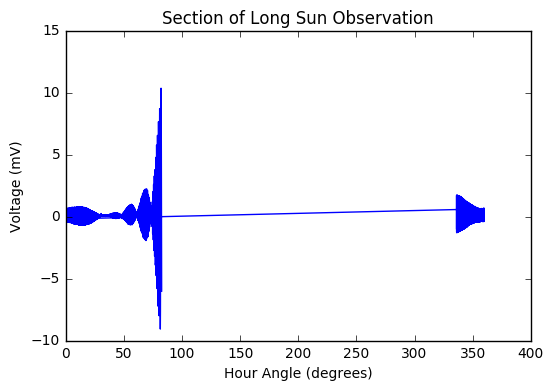

In [11]:
def f(x):
    return np.mean(x)*np.ones(len(x))
%matplotlib inline
plt.plot(h, volts*1000)
#plt.plot(h, f(volts))
plt.title("Section of Long Sun Observation")
plt.ylabel("Voltage (mV)")
plt.xlabel("Hour Angle (degrees)")
plt.savefig("sunsectionall.png")
plt.show()

### Baseline Fitting

Use a combination of Brute Force guessing values of Bew and Bns and Matrix Algebra least-squares to determine the baseline values. 

In [12]:
hsmall = h[500:600]
#voltssmall = voltsfilt[500:600]
voltssmall = volts[500:600]

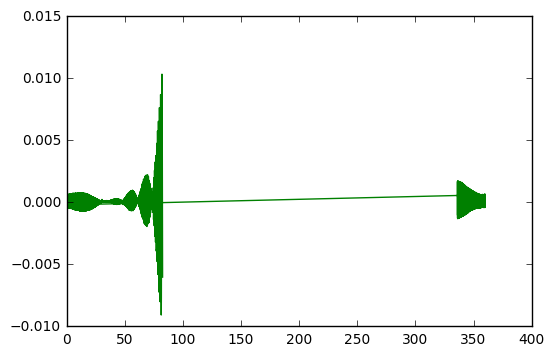

In [13]:
plt.plot(hsmall, voltssmall)
plt.plot(h, volts)
plt.show()

In [14]:
fit = np.polyfit(hsmall, voltssmall, 1)
a = fit[0]
b = fit[1]
print(type(b))

<type 'numpy.float64'>


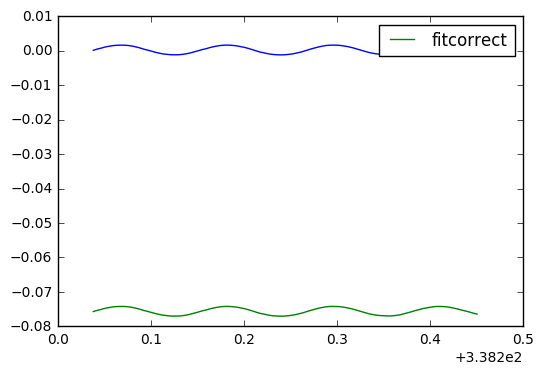

In [15]:
plt.plot(hsmall, voltssmall)
#plt.plot(np.array(hsmall), np.array(hsmall)*a + b)
plt.plot(np.array(hsmall), np.array(voltssmall)-b, label='fitcorrect')
plt.legend()
plt.show()

In [14]:
voltssmall = np.array(voltssmall)

In [15]:
hsmall = np.array(hsmall)*np.pi/180

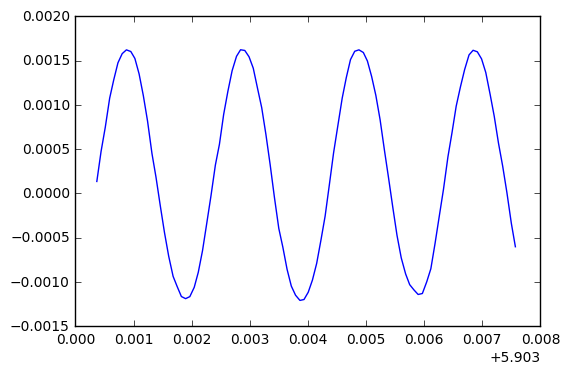

In [16]:
plt.plot(hsmall, voltssmall)
plt.show()

In [17]:
#Create Guesses for baseline components
ewvals = np.linspace(13, 22, 400)
nsvals = np.linspace(-2, 2, 178)

#Empty arrays to store results
avals = np.empty((len(ewvals), len(nsvals)), dtype=object)
s = np.empty((len(ewvals), len(nsvals)))
var = np.empty((len(ewvals), len(nsvals)), dtype=object)

Y = voltssmall
Y.shape = (-1, 1)

#Loop over the least squares process for
#Each guess of EW and each guess of NS
for i in range(len(ewvals)):
    for j in range(len(nsvals)):
        
        #Set Baseline components to current guess
        Bew = ewvals[i]
        Bns = nsvals[j]
        
        Qew = Bew*np.cos(d)/l
        Qns = Bns*np.sin(L)*np.cos(d)/l
        nutaug = Qew*np.sin(hsmall) + Qns*np.cos(hsmall)
        aterm = np.cos(2*np.pi*nutaug)
        bterm = np.sin(2*np.pi*nutaug)
        
        #perform least squares
        Xt = np.vstack((aterm, bterm))
        X = Xt.T
        xx = np.dot(Xt, X)
        xy = np.dot(Xt, Y)
        xxi = np.linalg.inv(xx)
        a = np.dot(xxi, xy)
        avals[i,j] = tuple(a)
        
        ybar = np.dot(X, a)
        dely = Y - ybar
        s_sq = np.dot(dely.T, dely)/(len(Y) - 2)
        s[i,j] = s_sq
        
        dxxi = np.diag(xxi)
        vardc = s_sq*dxxi
        var[i,j] = tuple(vardc)
        
    if (i%100 == 0):
        print(i)

0
100
200
300


In [18]:
minns = [(min(x), list(x).index(min(x))) for x in s]
nsindex = [x[1] for x in minns]
svals = [x[0] for x in minns]
ewindexval = list(svals).index(min(svals))
indexval = (ewindexval, nsindex[ewindexval])

In [19]:
indexval

(70, 176)

In [20]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

14.5789473684
1.97740112994


In [23]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

14.5789473684
1.97597597598


In [126]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

14.6028014007
1.87939698492


In [117]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

14.6126126126
1.8391959799


In [108]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

15.6026026026
-0.834170854271


In [76]:
3*np.sqrt(var[indexval])

array([[  1.01032335e-05 -2.81270498e-21j,
          9.76351698e-06 -2.71812909e-21j]])

In [118]:
3*np.sqrt(var[indexval])

array([[  8.82914967e-05,   8.71427714e-05]])

In [127]:
3*np.sqrt(var[indexval])

array([[  8.73577566e-05,   8.80785191e-05]])

In [133]:
3*np.sqrt(var[indexval])

array([[  8.91574548e-05,   8.62558343e-05]])

In [109]:
var[indexval]

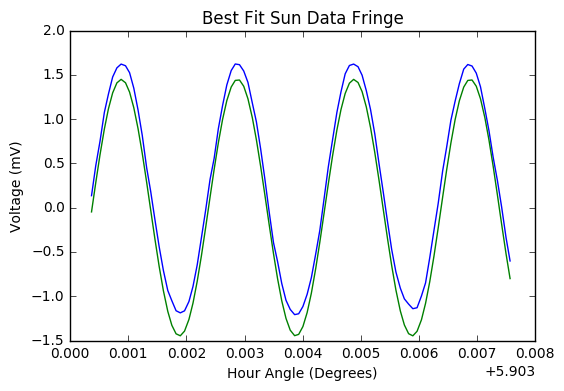

In [21]:
%matplotlib inline
voltssmall.shape = (100,)
Bew = ewvals[indexval[0]]
Bns = nsvals[indexval[1]]
Qew = Bew*np.cos(d)/l
Qns = Bns*np.sin(L)*np.cos(d)/l
nutaug = Qew*np.sin(hsmall) + Qns*np.cos(hsmall)
aterm = np.cos(2*np.pi*nutaug)
bterm = np.sin(2*np.pi*nutaug)
A, B = avals[indexval]
plt.plot(hsmall, voltssmall*1000, label='Data')
plt.plot(hsmall, (A[0]*aterm+B[0]*bterm)*1000, label='Model')
plt.subplot()
#plt.legend(loc = 'lower left')
plt.ylabel('Voltage (mV)')
plt.xlabel('Hour Angle (Degrees)')
plt.title('Best Fit Sun Data Fringe')
plt.savefig('VoltageFit12000.png')
plt.show()

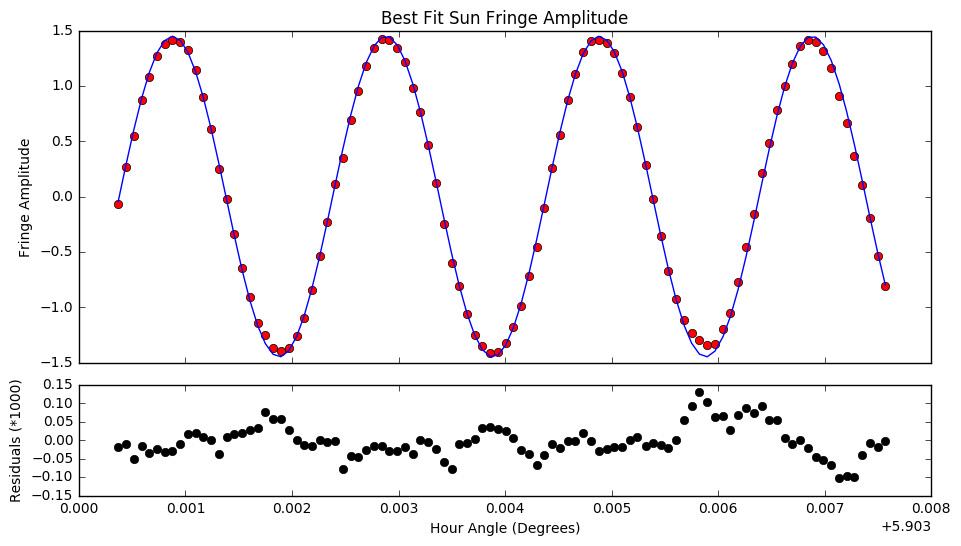

In [22]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
fig.subplots_adjust(hspace=0.1)
ax1 = axs[0]
ax1.plot(hsmall, (voltssmall-0.65*np.mean(voltssmall))*1000, 'ro')
ax1.plot(hsmall, (A[0]*aterm+B[0]*bterm)*1000)
ax1.title.set_text("Best Fit Sun Fringe Amplitude")
ax1.set_ylabel("Fringe Amplitude")
ax2 = axs[1]
ax2.plot(hsmall, 1000*((voltssmall-0.65*np.mean(voltssmall) - (A[0]*aterm+B[0]*bterm))), 'ko')
#ax2.set_ylim(-0.25, 0.1)
ax2.set_ylabel("Residuals (*1000)")
plt.xlabel("Hour Angle (Degrees)")
plt.savefig('BaselineFitWithResiduals.pdf')
plt.show()

In [23]:
np.mean((voltssmall-0.65*np.mean(voltssmall) - (A[0]*aterm+B[0]*bterm)))*1000

-0.0024562395636290404

### Diameter Fitting

In [112]:
#x = 2*pi*R*u #find x values of crossings
# convert to u values
# use formula to solve for R
#u = bx*cos(h)/l

In [186]:
bx = 20
l = consts.c/10.7e9
hnulls = np.array([np.mean([73.2, 74.1]), np.mean([60.795, 61.589]), np.mean([46.7368, 48.5508])])
x = [-3.8317, -7.0156, -10.1735]
u = bx*np.cos(hnulls*np.pi/180)/l
R = x/(2*np.pi*u)

<IPython.core.display.Javascript object>


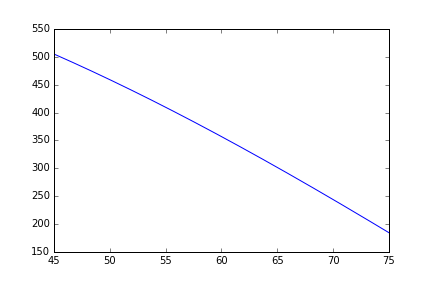

In [190]:
xvals = np.linspace(45, 75, 2000)
y = bx*np.cos(xvals*np.pi/180)/l
plt.plot(xvals, y)
plt.show()

<IPython.core.display.Javascript object>


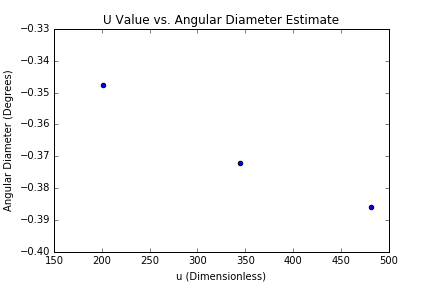

In [191]:
plt.scatter(u, 2*180*R/np.pi)
plt.title('U Value vs. Angular Diameter Estimate')
plt.ylabel('Angular Diameter (Degrees)')
plt.xlabel('u (Dimensionless)')
plt.show()

In [170]:
np.mean(2*180*np.array([R[0], R[2]])/np.pi)

0.42708363152810375